In [4]:
%pip install tensorflow opencv-python matplotlib numpy albumentations

  Using cached albumentations-1.3.1-py3-none-any.whl (125 kB)
  Using cached scipy-1.11.3-cp311-cp311-win_amd64.whl (44.1 MB)
  Using cached scikit_image-0.22.0-cp311-cp311-win_amd64.whl (24.5 MB)
     -------------------------------------- 144.7/144.7 kB 2.9 MB/s eta 0:00:00
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
     --------------------------------------- 38.0/38.0 MB 15.6 MB/s eta 0:00:00
  Using cached scikit_learn-1.3.1-cp311-cp311-win_amd64.whl (9.2 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached imageio-2.31.5-py3-none-any.whl (313 kB)
  Using cached tifffile-2023.9.26-py3-none-any.whl (222 kB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'd:\\Doki\\Д.моё\\portfolio\\python\\ml\\Tenserflow\\boobs_detector\\boobsdetector\\Lib\\site-packages\\cv2\\cv2.pyd'
Check the permissions.


[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as alb

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [156]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.20),
                         alb.RandomGamma(p=0.25),
                         alb.RGBShift(p=0.25),
                         alb.VerticalFlip(p=0.5)])

In [3]:
paths_boobs = os.listdir(os.path.join('data', 'boobs'))
paths_notboobs = os.listdir(os.path.join('data', 'notboobs'))

count_boobs = len(paths_boobs)
count_notboobs = len(paths_notboobs)

count_boobs, count_notboobs

(80, 80)

In [4]:
train_size_b = round(count_boobs * 0.8)
val_size_b = round(count_boobs * 0.1)
test_size_b = count_boobs - train_size_b - val_size_b

train_size_b, val_size_b, test_size_b

(64, 8, 8)

In [5]:
train_size_nb = round(count_notboobs * 0.8)
val_size_nb = round(count_notboobs * 0.1)
test_size_nb = count_notboobs - train_size_nb - val_size_nb

train_size_nb, val_size_nb, test_size_nb

(64, 8, 8)

In [6]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [164]:
def move_augmente(cat, folder_path):
    for partition, paths in folder_path:
        for path in paths:
            img = cv2.imread(os.path.join('data', cat, path))

            try:
                for x in range(10):
                    augmented = augmentor(image=img)
                    cv2.imwrite(os.path.join('aug_data',
                                            partition, cat,
                                            f'{path.split(".")[0]}.{x}.jpg'),
                                            augmented['image'])
            except Exception as e:
                print(e)


In [165]:
folder_path_b = [
    ('train', paths_boobs[0:train_size_b]),
    ('val', paths_boobs[train_size_b:train_size_b+val_size_b]),
    ('test', paths_boobs[train_size_b+val_size_b:count_boobs])
]

folder_path_nb = [
    ('train', paths_notboobs[0:train_size_nb]),
    ('val', paths_notboobs[train_size_nb:train_size_nb+val_size_nb]),
    ('test', paths_notboobs[train_size_nb+val_size_nb:count_notboobs])
]

move_augmente('boobs', folder_path_b)
move_augmente('notboobs', folder_path_nb)

        

        

image must be numpy array type


In [7]:
train_images_b = tf.data.Dataset.list_files('aug_data\\train\\boobs\\*.jpg', shuffle=False)
train_images_nb = tf.data.Dataset.list_files('aug_data\\train\\notboobs\\*.jpg', shuffle=False)

train_images = train_images_b.concatenate(train_images_nb)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (256,256)))
train_images = train_images.map(lambda x: x/255)



In [8]:
val_images_b = tf.data.Dataset.list_files('aug_data\\val\\boobs\\*.jpg', shuffle=False)
val_images_nb = tf.data.Dataset.list_files('aug_data\\val\\notboobs\\*.jpg', shuffle=False)

val_images = val_images_b.concatenate(val_images_nb)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (256,256)))
val_images = val_images.map(lambda x: x/255)

In [9]:
test_images_b = tf.data.Dataset.list_files('aug_data\\test\\boobs\\*.jpg', shuffle=False)
test_images_nb = tf.data.Dataset.list_files('aug_data\\test\\notboobs\\*.jpg', shuffle=False)

test_images = test_images_b.concatenate(test_images_nb)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (256,256)))
test_images = test_images.map(lambda x: x/255)

In [10]:
train_b = tf.ones(len(train_images_b))
train_nb = tf.zeros(len(train_images_nb))

train_b_labels = tf.data.Dataset.from_tensor_slices(train_b)
train_nb_labels = tf.data.Dataset.from_tensor_slices(train_nb)

train_labels = train_b_labels.concatenate(train_nb_labels)

In [11]:
val_b = tf.ones(len(val_images_b))
val_nb = tf.zeros(len(val_images_nb))

val_b_labels = tf.data.Dataset.from_tensor_slices(val_b)
val_nb_labels = tf.data.Dataset.from_tensor_slices(val_nb)

val_labels = val_b_labels.concatenate(val_nb_labels)

In [12]:
test_b = tf.ones(len(test_images_b))
test_nb = tf.zeros(len(test_images_nb))

test_b_labels = tf.data.Dataset.from_tensor_slices(test_b)
test_nb_labels = tf.data.Dataset.from_tensor_slices(test_nb)

test_labels = test_b_labels.concatenate(test_nb_labels)

In [13]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1270, 1270, 160, 160, 160, 160)

In [14]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(1500)
train = train.batch(8)
train = train.prefetch(4)

In [15]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(300)
test = test.batch(8)
test = test.prefetch(4)

In [16]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(300)
val = val.batch(8)
val = val.prefetch(4)

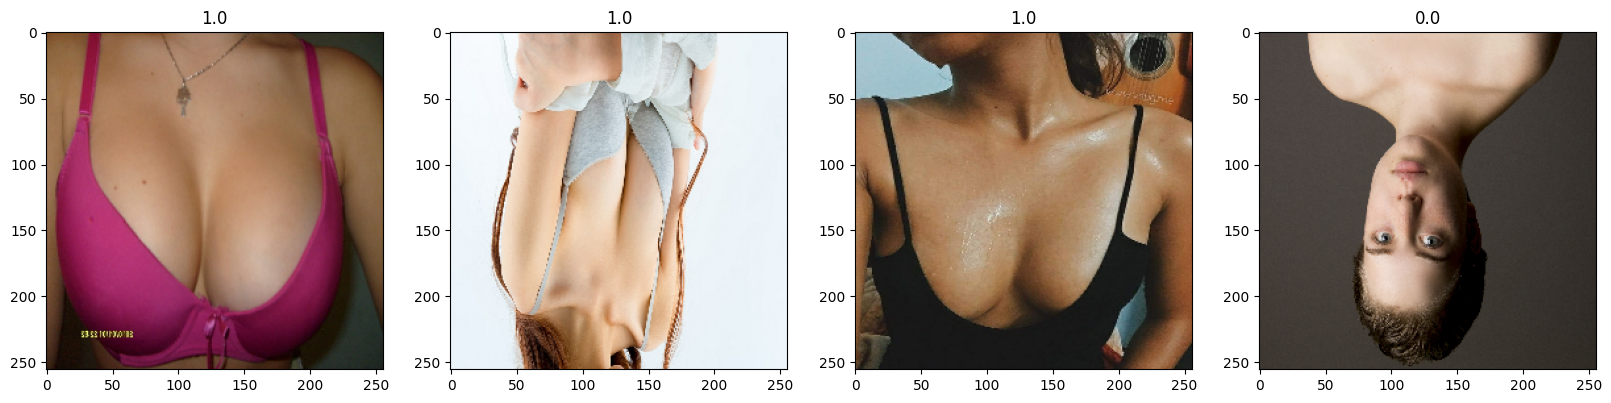

In [17]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()


fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]

    ax[idx].set_title(res[1][idx])
    ax[idx].imshow(sample_image)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dense, Flatten, Dropout

In [156]:
model = Sequential()

In [157]:
# First best model realisation
# model.add(Conv2D(16, (3, 3), 1, padding='same', activation='relu', input_shape=(256,256,3)))
# model.add(Conv2D(32, (3, 3), 1, padding='same', activation='relu'))
# model.add(Conv2D(64, (3, 3), 1, padding='same', activation='relu'))
# model.add(Conv2D(16, (3, 3), 1, padding='same', activation='relu'))
# model.add(GlobalMaxPooling2D())
# model.add(Dropout(0.2))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# Second best model realisation
model.add(Conv2D(64, (3, 3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), 1, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), 1, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

In [189]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [159]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 127, 127, 64)      0         
 ng2D)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 127, 127, 64)      0         
                                                                 
 conv2d_48 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 62, 62, 64)      

In [190]:
hist = model.fit(train, epochs=7, validation_data=val)

Epoch 1/7


159/159 [==============================] - 197s 1s/step - loss: 0.1649 - accuracy: 0.9992 - val_loss: 0.5952 - val_accuracy: 0.9187
Epoch 2/7
159/159 [==============================] - 191s 1s/step - loss: 0.1127 - accuracy: 1.0000 - val_loss: 0.5562 - val_accuracy: 0.9312
Epoch 3/7
159/159 [==============================] - 195s 1s/step - loss: 0.0843 - accuracy: 1.0000 - val_loss: 0.5248 - val_accuracy: 0.9125
Epoch 4/7
159/159 [==============================] - 195s 1s/step - loss: 0.0672 - accuracy: 1.0000 - val_loss: 0.5452 - val_accuracy: 0.9000
Epoch 5/7
159/159 [==============================] - 191s 1s/step - loss: 0.0657 - accuracy: 0.9961 - val_loss: 0.6436 - val_accuracy: 0.8750
Epoch 6/7
159/159 [==============================] - 193s 1s/step - loss: 0.0567 - accuracy: 0.9992 - val_loss: 0.6204 - val_accuracy: 0.9062
Epoch 7/7
159/159 [==============================] - 190s 1s/step - loss: 0.0487 - accuracy: 1.0000 - val_loss: 0.5533 - val_accuracy: 0.8813


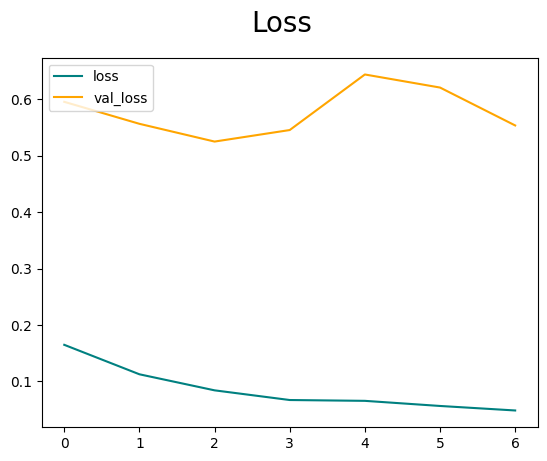

In [191]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

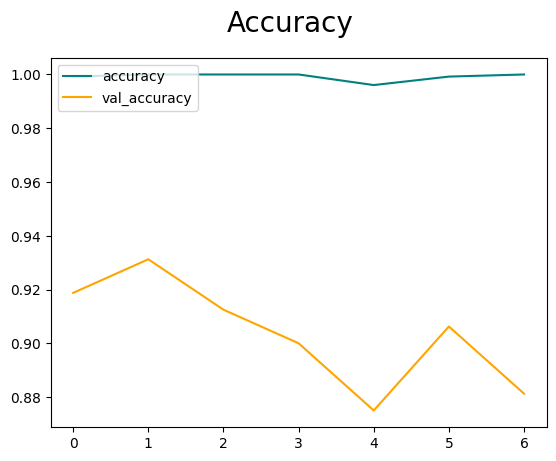

In [192]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

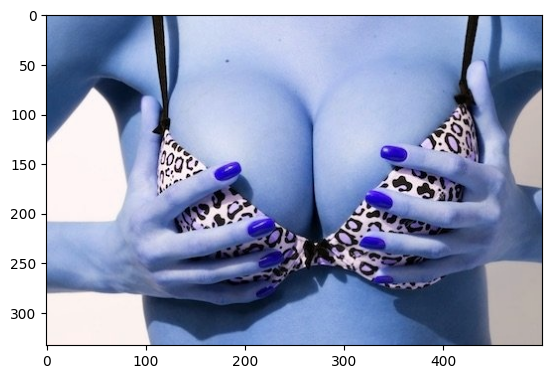

1/1 [==============================] - 0s 206ms/step


array([[5.031492e-12]], dtype=float32)

In [193]:
img = cv2.imread('data\\test\\boobs\\women-squeezing-their-breasts-women-touching-boobs.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

In [194]:
if yhat > 0.5:
    print(f'Boobs detected')
else:
    print(f'Boobs not detected')

Boobs not detected


In [50]:
from sklearn.metrics import classification_report

In [195]:
test_batch = test.as_numpy_iterator()

In [207]:
X, y = test_batch.next()
preds = model.predict(X)
preds = (preds.reshape(1, -1) > 0.5).astype(int)
print(classification_report(y, preds[0]))

1/1 [==============================] - 0s 201ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



In [103]:
from tensorflow.keras.models import load_model

In [208]:
model.save('boobsdetector_2.h5')

d:\Doki\Д.моё\portfolio\python\ml\Tenserflow\boobs_detector\boobsdetector\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = load_model('boobsdetector.h5')